# Project 2: What kind of wine is this?
## SGD route 3/5

In [60]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [61]:
train = pd.read_parquet("s3://ling583/wine-train.parquet", storage_options={"anon": True})
test = pd.read_parquet("s3://ling583/wine-test.parquet", storage_options={"anon": True})

In [62]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [63]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [64]:
predicted = sgd.predict(test["review_text"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.83      0.75      7558
        Chardonnay       0.82      0.85      0.84      4861
            Merlot       0.82      0.33      0.48      1381
        Pinot Noir       0.77      0.87      0.82      9618
          Riesling       0.80      0.79      0.80      2421
   Sauvignon Blanc       0.84      0.66      0.74      1278
             Syrah       0.75      0.54      0.63      3426
         Zinfandel       0.86      0.51      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.80      0.67      0.71     32625
      weighted avg       0.77      0.76      0.76     32625



---

## Decision function

In [65]:
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["review_text"])

In [66]:
labels

array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
       'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18')

In [67]:
scores[0,:]
# The first entry, looks like it was classified as Chardonnay since that has the highest value

array([-0.91421716, -0.59153672, -1.18795756, -1.30082701, -1.30191762,
       -1.22055674, -1.1937916 , -1.2754422 ])

In [68]:
# Lets look at what the data source has it tagged as 
test['wine_variant'].iloc[0]

'Chardonnay'

In [69]:
test['review_text'].iloc[0]

"hmmm. i have mixed emotions about this wine. on the one hand, i like it's minerality, but on the other, i think the acid is a bit whacked. on the one hand, it's a nice combo of fruit, but it has a funky finish. in the end, i wouldn't purchase it again."

In [70]:
highest = scores.max(axis=1)

In [71]:
highest[0]

-0.5915367229888091

In [72]:
# The instance that has the highest score in the whole dataset
highest.argmax()

30003

In [73]:
# These are the scores for that highest scoring article; the most solidly in one category
scores[30003]

array([-6.24274893, -7.76634215, -1.88980817, 11.13470105, -4.51810363,
       -4.27573661, -5.29510457, -2.59328838])

In [74]:
# what category was that wine?
test['wine_variant'].iloc[30003]

'Pinot Noir'

In [75]:
# Take a look at the review_text to see what made it score that high for that category
test['review_text'].iloc[30003]

'this to me is a very pleasant, somewhat innocuous Pinot. Beautiful clear cherry colour, intense typical pinot nose of strawberry and red cherry, a little candied, and not giving up any pinot "funk". Palate is medium bodied for a pinot, lots of sweet cherry and strawberry fruit, maybe a little raspberry, nice acidity and low tannins, but lacking much complexity or "wow". Solid.'

In [76]:
# find the article where the highest value within the article is the lowest for that category
highest.argmin()

15256

In [77]:
# looks like we assigned it to the Merlot category
scores[10441]

array([-1.03386903, -1.21963577, -1.13820297, -1.18544596, -1.81132635,
       -1.94491078, -1.38953799, -1.21904177])

In [78]:
# it is actually a Syrah
test['wine_variant'].iloc[10441]

'Syrah'

In [79]:
test['review_text'].iloc[10441]

'Black fruit, very spicy, a certain sharpness; full, rounded, almost sweet on the attack, good fruit, vanilla, good weight, attractive but a bit heavy; good length, slightly edgy. Not a perfect bottle?'

In [80]:
# Each row is a single test example, columns are the 4 classes
print(scores[0:5,:])

[[-0.91421716 -0.59153672 -1.18795756 -1.30082701 -1.30191762 -1.22055674
  -1.1937916  -1.2754422 ]
 [-1.85955469 -2.18956274 -1.15189218 -1.46690088 -2.59268997  0.63932941
   0.71990302 -1.75302928]
 [-1.15436242 -1.98191743 -1.13756684  1.05110735 -1.75461611 -1.938044
  -1.8747448  -1.28005751]
 [-1.56183083 -4.55272211 -1.21702344  1.38560418 -3.87471479 -2.47826185
  -1.66635545 -0.98370125]
 [-3.85156343 -1.98670387 -1.43443435 -4.28874008 -2.067764   -1.92686402
  -2.98513302  3.94012131]]


In [81]:
# we want to see how close the highest and second highest scores are for each instance. Start by sorting the arrays
# The issue here is that we lose the context of what score is associated to what category
scores.sort(axis=1)
scores[0:5,:]

array([[-1.30191762, -1.30082701, -1.2754422 , -1.22055674, -1.1937916 ,
        -1.18795756, -0.91421716, -0.59153672],
       [-2.59268997, -2.18956274, -1.85955469, -1.75302928, -1.46690088,
        -1.15189218,  0.63932941,  0.71990302],
       [-1.98191743, -1.938044  , -1.8747448 , -1.75461611, -1.28005751,
        -1.15436242, -1.13756684,  1.05110735],
       [-4.55272211, -3.87471479, -2.47826185, -1.66635545, -1.56183083,
        -1.21702344, -0.98370125,  1.38560418],
       [-4.28874008, -3.85156343, -2.98513302, -2.067764  , -1.98670387,
        -1.92686402, -1.43443435,  3.94012131]])

In [82]:
# Calculate the margins for the scores, That is the difference betwen the top and second score
margin = scores[:,3]-scores[:,2]

In [83]:
margin.max(), margin.min()

(2.7959465899108884, 3.1374356106450563e-06)

In [84]:
# We just want to see those where the margin is large
minmarg = 1.06
print(classification_report(test["wine_variant"][margin > minmarg], predicted[margin > minmarg]))

# The only way to break a Macro avg F-1 score over 0.85 is to exclude all but the one review with the highest margin.

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.80      0.75       473
        Chardonnay       0.88      0.94      0.91        65
            Merlot       0.70      0.16      0.26        86
        Pinot Noir       0.66      0.85      0.74       436
          Riesling       0.88      0.82      0.85        17
   Sauvignon Blanc       0.85      0.74      0.79        23
             Syrah       0.67      0.45      0.54       186
         Zinfandel       0.88      0.34      0.49       108

          accuracy                           0.70      1394
         macro avg       0.78      0.64      0.67      1394
      weighted avg       0.71      0.70      0.68      1394



In [85]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'F1')

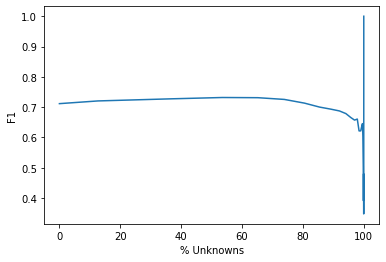

In [86]:
thresh = np.linspace(-2, 3, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["wine_variant"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1')

In [87]:
print(classification_report(test["wine_variant"][margin > 1.75], predicted[margin > 1.75]))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.63      0.80      0.71        30
            Merlot       0.00      0.00      0.00         9
        Pinot Noir       0.68      0.88      0.77        43
          Riesling       1.00      1.00      1.00         2
   Sauvignon Blanc       1.00      1.00      1.00         1
             Syrah       0.67      0.50      0.57        12
         Zinfandel       1.00      0.10      0.18        10

          accuracy                           0.67       107
         macro avg       0.71      0.61      0.60       107
      weighted avg       0.65      0.67      0.62       107



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**TO DO:** Summarize your results for this section. What could we do if we wanted to make label as many examples as possible while still keeping F1 above 0.99?

The article that had the highest category score in this model conveniently had very low scores for the other 3 categories with a margin of about 7.79. When keeping only those articles with a margin greater than 5, there was an accuracy of 100% but we only return 93 articles or about 1.9% of all articles. When dropping the margin to 1.75, that netted us 3772 articles or about 79% of the total while keeping 99% accuracy.

If we wanted to keep our F1 above 99% while maximizing our supporting articles, we could adjust the minimum margin required until it meets our needs. GVIO is the category that gives us the most trouble with this, thus pushing our minimum margin higher and our supporting articles lower. At minimum margin 2.2, all categories are at 1.00 F1 score except for GVIO which is at 0.99. GVIO doesn't reach F1 1.00 until minimum margin of 4.0. 

With the minimum margin at 2.2 we get 3145 supporting articles while at 4.0 (which we need in order to get GVIO to F1 1.00) we only get 482 articles.

In [ ]:
print("margin > 2.2\n", classification_report(test["wine_variant"][margin > 2.2], predicted[margin > 2.2])) # optimal for all but GVIO
print()
print("margin > 3.9\n",classification_report(test["wine_variant"][margin > 3.9], predicted[margin > 3.9])) # to show that GVIO is still at 0.99
print()
print("margin > 4.0\n",classification_report(test["wine_variant"][margin > 4], predicted[margin > 4])) # optimal for all categories

---

## Model parameters

In [89]:
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
        'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18'),
 array([[ 1.16482924, -0.55363625, -0.25354167, ...,  0.        ,
         -0.1048644 ,  0.        ],
        [-0.08407375, -0.31999472,  0.00631175, ...,  0.26560864,
          0.        ,  0.        ],
        [ 0.14787126, -0.04511793,  0.01095268, ...,  0.        ,
          0.18685405,  0.        ],
        ...,
        [-0.19029645, -0.13281826,  0.32686988, ...,  0.        ,
          0.        ,  0.        ],
        [-0.21091609,  0.43103112,  0.09219502, ...,  0.12213975,
         -0.23696212, -0.09053757],
        [-0.10272099,  0.33217593,  0.01105158, ...,  0.        ,
         -0.01911391,  0.        ]]))

In [90]:
coef.shape

(8, 15214)

In [91]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names()

In [92]:
coef[0,:].argmax()

2092

In [93]:
coef[0,2092]

13.250273793323963

In [94]:
vocab[2092]

'cab'

This means that for the GJOB category, each occurance of the word "jobs" gives a weight of 4.522631071356675

In [95]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

Cabernet Sauvignon
  cab             13.250
  cabernet        11.977
  cabs             8.917
  cassis           8.090
  bordeaux         5.489
  currant          5.310
  napa             5.308
  tannins          4.821
  bell             4.530
  caymus           4.456
  chard           -3.717
  zins            -3.898
  pinots          -4.034
  merlots         -4.240
  chardonnay      -4.357
  zinfandel       -4.688
  burgundy        -4.729
  zin             -7.275
  syrah           -8.293
  pinot           -9.024

Chardonnay
  chardonnay      11.614
  chard            9.505
  chablis          8.474
  buttery          6.714
  chards           6.555
  butter           6.479
  chardonnays      5.927
  meursault        5.880
  butterscotch     4.928
  premox           4.830
  cab             -4.165
  dark            -4.207
  cherries        -4.214
  sb              -4.479
  red             -4.724
  pinot           -4.839
  sauvignon       -5.157
  riesling        -6.076
  tannins         -

In [96]:
from kwic import kwic

In [97]:
kwic('carlisle', train['review_text'])

894,nice wine. Leans more towards some blacker fruits than I usually get with,Carlisle,"'s but still very fresh and bright. Some moderate tannin, but a pure pleasu"
1755,pen for business now. I am always amazed at how good these base bottles of,Carlisle,are...a real credit to the Officer/Maddox team.
2428,"Big, forceful wine that lacked the balance I normally feel in",Carlisle,". Almost metallic backbone and loads of fruit, brambles, and cocoa notes. G"
2682,"d extraction, with a touch of heat. Finish is shorter than most of the the",Carlisle,"zins. Enjoyable, but not to the level of most of his zins."
3128,"fruit, just enough spice. Too bad it was my last bottle. Drank alongside a",Carlisle,"2008 Dry Creek Valley Zinfandel - also quite good, but not in the same lea"
3128,. Wife and I tried to keep this bottle to ourselves. Can't wait to get the,Carlisle,fall release order form.
5343,A rare,Carlisle,"that I didn't really enjoy. Must have been an ""off"" bottle since everyone"
5505,"ering"". Finished 5th (my 2nd place) against some pretty good zins: Another",Carlisle,", Valdez, Turley, and Green and Red Child Mills. I would recommend decanti"
5573,ntinue to evolve and improve for a couple of years or more. James Berry +,Carlisle,+ a good vintage = YUMMY!
6549,"hat matter Nalle, even though it isn't OTT and has some structure, and NOT",Carlisle,"'s comprehensive package, and thus not quite that good a QPR) and in terms"


In [98]:
kwic('lodi', train['review_text'])

461,"Very strange, I liked this wine in",Lodi,"the first time, but it tasted like a Zinfandelish Cab. Definite hints of Z"
1767,well integrated into the spicy red fruit. Reminds me of some of the better,Lodi,zins I've tried.
2244,"ses dark cherries, alcohol, oak chips, charcoal and tar in an almost jammy",Lodi,style but stops short of this. Finish is full of cherries and brambles. Ve
2606,A tasty,Lodi,Zin- not too big or overpowering with the fruit- Alc in check as well. The
4519,"Nice, not the fruit bomb I am used to from a",Lodi,winery but believe the grapes are from Napa which would make perfect sense
6628,e been to the winery and really like this Zin. We have had others from the,Lodi,area and this is still our favorite. Great price. Very drinkable now with
7458,This wine is made from 80 - 100 year-old vines sourced from Oakley and,Lodi,vineyard and spends 9 months in American oak. Medium red/purple color. At
8834,"in, plenty of acid. Hot in the finish. Not nearly as big as we expect from",Lodi,", but better for it. Poor value at $52 direct with shipping, but very good"
10629,"d - fully loaded, ready to go. Not as good as Deerfield Ranchs' Zinfandel,",Lodi,"Zins, or Paso Robles zins, but this wine is right under those. The cork po"
10629,t was gone. This is not the thickest zin that you would see from a paso or,lodi,"zin, but then again I was not expecting that given its origin in Lake Coun"
